In [224]:
from graph_ds import PyH3Graph
from pois_to_h3 import get_pois_h3
from ghsl_processing import get_origins, city_boundaries_to_h3 

import pandas as pd
import h3.api.numpy_int as h3
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
import numpy as np
import seaborn as sns
import pickle


def plot_hex_df(df, markersize, color_column=None, color_categorical=False):
    df[['y','x']] = list(df['h3_index'].apply(h3.h3_to_geo))
    # Convert the pandas DataFrame to a GeoPandas DataFrame with a Point geometry column
    gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x, df.y))

    fig, ax = plt.subplots(figsize=(10,10))
    # Show the GeoPandas DataFrame

    if color_column:
        gdf.plot(ax=ax, column=color_column, categorical=color_categorical,
                  legend=True, markersize=markersize, alpha=0.5, cmap='Reds',
                  vmin=0, vmax=25)
    else:
        gdf.plot(ax=ax, markersize=markersize, alpha=0.5)

    #plt.xlim(12.391681,12.737388)
    #plt.ylim(55.549206, 55.759991)

    cx.add_basemap(ax = ax, crs="EPSG:4326")
    #plt.show()

def routing(category_set, origins, destinations, num_origins, graph):
    mins={}
    category_travel_time_means = {}
    for c in category_set:
        cat_destinations = list(destinations[destinations['category']==c]['h3_index'])
        ds = graph.matrix_distance(origins=origins, destinations=cat_destinations, dynamic_infinity=True, hour_of_week=144)

        # they might be different lengths, so we can't use a df
        mins[c]={k:np.nanmin(np.array(v,dtype=np.float64)) for k,v in ds.items() if v}
        category_travel_time_means[c] = np.nanmean(list(mins[c].values()))

    return category_travel_time_means, mins


In [225]:
# # denver, cl
# osm_file = "../resources/denver/denver-processed.osm.pbf"
# gtfs_files = ["../resources/denver/denver_gtfs.zip"]
# ghsl_file = "../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R5_C10.tif"

# city_names = ["Denver, Colorado"]

# copehagen, dk
# osm_file = "../resources/processed/København Kommune_processed.osm.pbf"
# gtfs_files = ["../resources/copenhagen/rejseplanen.zip"]
# ghsl_file = "../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif"

# city_names = ["København Kommune", "Frederiksberg Kommune"]

city_names = ["Dragør Kommune"]
osm_file = "../resources/processed/Dragør Kommune_processed.osm.pbf"
gtfs_files = ["../resources/copenhagen/rejseplanen.zip"]
ghsl_file = "../resources/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R3_C19_Denmark.tif"

# # Los Angeles
# osm_file = "../resources/la/la-processed.osm.pbf"
# gtfs_files = ["../resources/la/gtfs_bus.zip", "../resources/la/gtfs_rail.zip"]
# ghsl_file = "../resources/la/GHS_BUILT_C_MSZ_E2018_GLOBE_R2022A_54009_10_V1_0_R5_C8_SoCal.tif"

# city_names = ["Los Angeles"]

In [226]:
# Parameters

# 12 is around 10 meter resolution
H3_RES = 12

# how many origins to sample
num_origins = 10000

#essential filter will be the least restrictive
essential_filter = {
    "amenity":["pharmacy","dentist","clinic","doctors","school","library"],
    "shop":["supermarket","greengrocer","medical_supply","grocery","wholesale"],
    "healthcare":["clinic","doctor","pharmacy","dentist"],
    "leisure":["park","fitness_centre",'fitness_station'], 
    "sport":['tennis','soccer','swimming_pool','sports_centre','pitch','track','golf_course','gymnastics','gym','fitness_centre','fitness_station']
    }

# categories considered for the n-minute calculation
category_set = ['pharmacy','park','supermarket','sport', 'school','library']

# how to map osm tags to categories
osm_tag_mapping = {
    "medical_supply":"pharmacy",
    "greengrocer":"supermarket",
    "wholesale":"supermarket",
    "grocery":"supermarket",
    "clinic":"doctor",
    "doctors":"doctor",
    'pitch':'sport',
    'track':'sport',
    'sports_centre':'sport',
    'fitness_centre':'sport',
    'fitness_station':'sport'
}

In [227]:
results = {}

city_bounds_h3, bbox, bbox_pois = city_boundaries_to_h3(city_names)

origins = get_origins(H3_RES, city_names, bbox, ghsl_file, city_bounds_h3)
print("origins", len(origins))

origins_sample = list(origins[origins['residential_bool']==1].sample(num_origins, replace=True)['h3_index'])

destinations = get_pois_h3(osm_file, essential_filter, H3_RES, category_set, osm_tag_mapping, city_names)

# for g_type in ['all', 'walk', 'walk+bike', 'walk+transit']:
for g_type in ['all']:
        print(g_type)
        # build the graph
        graph = PyH3Graph(weight_options={}, k_ring=2, layers=g_type)
        graph.create(osm_path=osm_file,gtfs_paths=gtfs_files)
        # do routing
        category_means, route_mins = routing(category_set, origins_sample, destinations, num_origins, graph)
        # save results as dictionary
        results.update({g_type:{'category_means':category_means, 'route_mins':route_mins}})

file already exists for Dragør Kommune
origins 15032
file already exists for Dragør Kommune
all
processing osm pbf file: ../resources/processed/Dragør Kommune_processed.osm.pbf
converted OSM file into 91508 edges
osm graph created with 81894 nodes in 1.2556579 s
getting GTFS feed from ../resources/copenhagen/rejseplanen.zip
routes: 1631
gtfs graph created with 103525 nodes in 9.133378 s
merged gtfs graph into osm graph, now has 185096 nodes, took 84 ms
hash: 11924115022887346488


/tmp/ipykernel_584474/3000639366.py:44: RuntimeWarning:

All-NaN slice encountered



In [228]:
import polars as pl
from lets_plot import *
from lets_plot import tilesets

LetsPlot.setup_html()

In [229]:
result_data = []
for g_type, result in results.items():
    route_mins = result['route_mins']
    for category, values in route_mins.items():
        for h3_index, value in values.items():
            lat, lon = h3.h3_to_geo(h3_index)
            result_data.append([g_type, category, h3_index, lat, lon, value])

result_df = pl.DataFrame(result_data, columns=['graph_type', 'category', 'h3', 'lat', 'lon', 'travel_time'])

result_df.head()

/tmp/ipykernel_584474/865589535.py:9: DeprecationWarning:

`columns` is deprecated as an argument to `__init__`; use `schema` instead.



shape: (5, 6)
┌────────────┬──────────┬────────────────────┬───────────┬───────────┬─────────────┐
│ graph_type ┆ category ┆ h3                 ┆ lat       ┆ lon       ┆ travel_time │
│ ---        ┆ ---      ┆ ---                ┆ ---       ┆ ---       ┆ ---         │
│ str        ┆ str      ┆ i64                ┆ f64       ┆ f64       ┆ f64         │
╞════════════╪══════════╪════════════════════╪═══════════╪═══════════╪═════════════╡
│ all        ┆ pharmacy ┆ 631049686425746431 ┆ 55.569707 ┆ 12.604656 ┆ 44.442677   │
│ all        ┆ pharmacy ┆ 631049686394778111 ┆ 55.583722 ┆ 12.635756 ┆ 21.032963   │
│ all        ┆ pharmacy ┆ 631049687654208511 ┆ 55.583987 ┆ 12.645503 ┆ 16.914669   │
│ all        ┆ pharmacy ┆ 631049687663577599 ┆ 55.588964 ┆ 12.642035 ┆ 9.821878    │
│ all        ┆ pharmacy ┆ 631049687655010815 ┆ 55.582174 ┆ 12.647687 ┆ 19.248693   │
└────────────┴──────────┴────────────────────┴───────────┴───────────┴─────────────┘

In [93]:
result_df.write_ipc(f'results_{city_names[0]}.feather')

In [170]:
result_df = pl.read_ipc(f'results_{city_names[0]}.feather')

In [230]:
plot_df = result_df.filter((pl.col('travel_time').is_not_nan()))

In [172]:
# ggplot(plot_df) + \
#     geom_livemap(tiles=tilesets.LETS_PLOT_DARK) + \
#     geom_point(aes(x='lon', y='lat'), size=0.5, alpha=0.7) + \
#     ggtitle(f"Origins in Copenhagen")

In [173]:
# ggplot(plot_df.filter(pl.col('travel_time') < 60)) + \
#     geom_point(aes(x='lon', y='lat', color='travel_time'), alpha=0.5) + \
#     scale_color_gradient(low='#f2f0f7', high='#54278f') + \
#     facet_wrap(["graph_type", "category"], ncol=6) + \
#     coord_fixed() + \
#     ggtitle(f"Minimum travel times to essential services in [{city_names[0]}]") + \
#     ggsize(1000, 700)

In [231]:
plot_df.filter(pl.col('graph_type') == 'all').groupby('category').agg(
    pl.col('travel_time').mean().alias('mean_travel_time'),
    pl.col('travel_time').std().alias('std_travel_time'),
    pl.col('travel_time').median().alias('median_travel_time'),
    pl.col('travel_time').quantile(0.95).alias('95th_percentile_travel_time'),
)

shape: (6, 5)
┌─────────────┬──────────────────┬─────────────────┬────────────────────┬──────────────────────────┐
│ category    ┆ mean_travel_time ┆ std_travel_time ┆ median_travel_time ┆ 95th_percentile_travel_t │
│ ---         ┆ ---              ┆ ---             ┆ ---                ┆ ime                      │
│ str         ┆ f64              ┆ f64             ┆ f64                ┆ ---                      │
│             ┆                  ┆                 ┆                    ┆ f64                      │
╞═════════════╪══════════════════╪═════════════════╪════════════════════╪══════════════════════════╡
│ library     ┆ inf              ┆ NaN             ┆ 11.808632          ┆ 39.262852                │
│ supermarket ┆ inf              ┆ NaN             ┆ 7.643141           ┆ 29.379305                │
│ school      ┆ inf              ┆ NaN             ┆ 9.707244           ┆ 39.068707                │
│ pharmacy    ┆ inf              ┆ NaN             ┆ 12.345774          ┆ 41.724644                │
│ sport       ┆ inf              ┆ NaN             ┆ 8.859783           ┆ 22.941792                │
│ park        ┆ inf              ┆ NaN             ┆ 6.538674           ┆ 31.035408                │
└─────────────┴──────────────────┴─────────────────┴────────────────────┴──────────────────────────┘

In [232]:
cat_df = plot_df.filter((pl.col('graph_type') == 'all') & (pl.col('category') != 'library')).groupby('h3').agg(
    pl.col('travel_time').arg_max().alias('max_travel_time'),
    pl.col('category').take(pl.col('travel_time').arg_max()).alias('max_travel_time_category'),
).groupby('max_travel_time_category').agg(
    pl.col('h3').count().alias('num_origins')
).with_columns(
    pl.col('num_origins') / pl.col('num_origins').sum() * 100
)

cat_df.head()

shape: (4, 2)
┌──────────────────────────┬─────────────┐
│ max_travel_time_category ┆ num_origins │
│ ---                      ┆ ---         │
│ str                      ┆ f64         │
╞══════════════════════════╪═════════════╡
│ supermarket              ┆ 0.56391     │
│ pharmacy                 ┆ 49.185464   │
│ school                   ┆ 20.426065   │
│ sport                    ┆ 29.824561   │
└──────────────────────────┴─────────────┘

In [207]:
ggplot(cat_df) + \
    geom_bar(aes(x='max_travel_time_category', y='num_origins'), stat='identity')

In [208]:
ggplot(plot_df) + \
    geom_density(aes(x='travel_time', fill='category'), alpha=0.3) + \
    xlim(0, 30) + \
    facet_wrap(["graph_type"], ncol=5) + \
    ggtitle(f"Minimum travel time to essential services in [{city_names[0]}], grouped by network type")

In [209]:
benefit_df = plot_df.groupby(['h3', 'category']).agg(
    pl.col('travel_time'),
    pl.col('travel_time').len().alias('count'),
).filter(pl.col('count') == 4).groupby(['h3', 'category']).agg(
    (pl.col('travel_time').flatten().take(1) - pl.col('travel_time').flatten().take(2)).alias('bike_benefit'),
    (pl.col('travel_time').flatten().take(1) - pl.col('travel_time').flatten().take(3)).alias('transit_benefit'),
    (pl.col('travel_time').flatten().take(1) - pl.col('travel_time').flatten().take(0)).alias('multimodal_benefit'),
    (pl.col('travel_time').flatten().take(3) - pl.col('travel_time').flatten().take(2)).alias('transit_bike_benefit'),
).sort('category')

In [210]:
p = ggplot(benefit_df) + \
    geom_histogram(aes(x='multimodal_benefit', fill='category'), alpha=0.5, bins=30) + \
    geom_vline(xintercept=benefit_df['multimodal_benefit'].quantile(0.5), linetype="dashed", color="black") + \
    geom_vline(xintercept=benefit_df['multimodal_benefit'].quantile(0.8), linetype="dashed", color="black") + \
    geom_vline(xintercept=benefit_df['multimodal_benefit'].quantile(0.9), linetype="dashed", color="black") + \
    xlim(0, 30) + \
    xlab("benefit in minutes")

ggsave(p, f"multimodal_benefit_{city_names[0]}.png")

p.show()

In [180]:
benefit_df.head()

shape: (5, 6)
┌──────────────────┬──────────┬──────────────┬─────────────────┬─────────────────┬─────────────────┐
│ h3               ┆ category ┆ bike_benefit ┆ transit_benefit ┆ multimodal_bene ┆ transit_bike_be │
│ ---              ┆ ---      ┆ ---          ┆ ---             ┆ fit             ┆ nefit           │
│ i64              ┆ str      ┆ f64          ┆ f64             ┆ ---             ┆ ---             │
│                  ┆          ┆              ┆                 ┆ f64             ┆ f64             │
╞══════════════════╪══════════╪══════════════╪═════════════════╪═════════════════╪═════════════════╡
│ 6311821301983083 ┆ library  ┆ 2.020963     ┆ 0.0             ┆ 2.020963        ┆ 2.020963        │
│ 51               ┆          ┆              ┆                 ┆                 ┆                 │
│ 6311821301591178 ┆ library  ┆ 7.970442     ┆ 15.751863       ┆ 13.601862       ┆ -7.781422       │
│ 23               ┆          ┆              ┆                 ┆                 ┆                 │
│ 6311821296318151 ┆ library  ┆ 8.203407     ┆ 0.0             ┆ 8.203407        ┆ 8.203407        │
│ 67               ┆          ┆              ┆                 ┆                 ┆                 │
│ 6311821303363927 ┆ library  ┆ 0.122655     ┆ 0.0             ┆ 0.122655        ┆ 0.122655        │
│ 03               ┆          ┆              ┆                 ┆                 ┆                 │
│ 6311821294527708 ┆ library  ┆ 1.930362     ┆ 0.0             ┆ 1.930362        ┆ 1.930362        │
│ 15               ┆          ┆              ┆                 ┆                 ┆                 │
└──────────────────┴──────────┴──────────────┴─────────────────┴─────────────────┴─────────────────┘

In [181]:
benefit_df.groupby("category").agg(
    pl.col('bike_benefit').mean().alias('bike_benefit'),    
    pl.col('transit_benefit').mean().alias('transit_benefit'),
    pl.col('multimodal_benefit').mean().alias('multimodal_benefit'),
)

shape: (6, 4)
┌─────────────┬──────────────┬─────────────────┬────────────────────┐
│ category    ┆ bike_benefit ┆ transit_benefit ┆ multimodal_benefit │
│ ---         ┆ ---          ┆ ---             ┆ ---                │
│ str         ┆ f64          ┆ f64             ┆ f64                │
╞═════════════╪══════════════╪═════════════════╪════════════════════╡
│ sport       ┆ 1.231032     ┆ 0.762573        ┆ 1.762692           │
│ library     ┆ 4.570676     ┆ 3.045524        ┆ 5.711348           │
│ school      ┆ 0.799109     ┆ 0.755709        ┆ 1.318422           │
│ supermarket ┆ 2.557319     ┆ 1.777           ┆ 3.499352           │
│ pharmacy    ┆ 5.134802     ┆ 4.185626        ┆ 6.468226           │
│ park        ┆ 0.473601     ┆ 0.603545        ┆ 0.962189           │
└─────────────┴──────────────┴─────────────────┴────────────────────┘

In [233]:
plot_df.filter(pl.col('category') != 'library').groupby(["graph_type", "h3"]).agg(
    pl.col('travel_time').max().alias('max_travel_time'),
).groupby('graph_type').agg(
    pl.col('max_travel_time').median().alias('median_travel_time'),
    pl.col('max_travel_time').quantile(0.95).alias('95th_percentile_travel_time'),
)

shape: (1, 3)
┌────────────┬────────────────────┬─────────────────────────────┐
│ graph_type ┆ median_travel_time ┆ 95th_percentile_travel_time │
│ ---        ┆ ---                ┆ ---                         │
│ str        ┆ f64                ┆ f64                         │
╞════════════╪════════════════════╪═════════════════════════════╡
│ all        ┆ 13.223747          ┆ 41.918789                   │
└────────────┴────────────────────┴─────────────────────────────┘

In [183]:
map_df = plot_df.groupby(["graph_type", "h3"]).agg(
    pl.col('travel_time').max().alias('max_travel_time'),
    pl.col('lat').first().alias('lat'),
    pl.col('lon').first().alias('lon'),
).filter(pl.col('graph_type') == 'all').filter(
    (pl.col('max_travel_time') < pl.col('max_travel_time').quantile(0.95))
      & (pl.col('max_travel_time') > pl.col('max_travel_time').quantile(0.05))
)

map_df.head()

shape: (5, 5)
┌────────────┬────────────────────┬─────────────────┬───────────┬─────────────┐
│ graph_type ┆ h3                 ┆ max_travel_time ┆ lat       ┆ lon         │
│ ---        ┆ ---                ┆ ---             ┆ ---       ┆ ---         │
│ str        ┆ i64                ┆ f64             ┆ f64       ┆ f64         │
╞════════════╪════════════════════╪═════════════════╪═══════════╪═════════════╡
│ all        ┆ 631182127923898879 ┆ 15.5316         ┆ 39.717736 ┆ -104.91817  │
│ all        ┆ 631182130366925311 ┆ 8.536207        ┆ 39.752014 ┆ -104.96422  │
│ all        ┆ 631182123760101887 ┆ 14.662583       ┆ 39.671087 ┆ -104.876199 │
│ all        ┆ 631182124011514367 ┆ 11.842841       ┆ 39.680844 ┆ -104.983823 │
│ all        ┆ 631182124049107455 ┆ 21.609938       ┆ 39.721305 ┆ -104.929562 │
└────────────┴────────────────────┴─────────────────┴───────────┴─────────────┘

In [184]:
import geopandas as gpd

neis = gpd.read_file("https://wfs-kbhkort.kk.dk/k101/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=k101:kvarter&outputFormat=json&SRSNAME=EPSG:4326")[['kvarternavn', 'geometry']]
data = gpd.GeoDataFrame(map_df.to_pandas(), geometry=gpd.points_from_xy(map_df['lon'], map_df['lat']), crs=neis.crs)
neis.head()

kvarternavn  \
0               Middelalderbyen   
1                 Metropolzonen   
2         Nansensgade-Kvarteret   
3  Øster Farimagsgade-kvarteret   
4                     Østerport   

                                            geometry  
0  MULTIPOLYGON (((12.58005 55.67215, 12.58011 55...  
1  MULTIPOLYGON (((12.57140 55.67555, 12.57111 55...  
2  MULTIPOLYGON (((12.56247 55.68027, 12.56035 55...  
3  MULTIPOLYGON (((12.57616 55.68629, 12.57377 55...  
4  MULTIPOLYGON (((12.59907 55.68887, 12.59912 55...

In [185]:
frb = gpd.read_file("https://admin.opendata.dk/dataset/f9cf5ee0-00bd-4ead-b5e8-4b3296b13e88/resource/5139ce4d-a08d-4f18-9fe0-6630661eb856/download/skoledistrikter.geojson")
frb = frb.to_crs(neis.crs).rename(columns={'navn': 'kvarternavn'})[['kvarternavn', 'geometry']]
frb.head()

kvarternavn                                           geometry
0         Skole ved Søerne  MULTIPOLYGON (((12.55382 55.68180, 12.55369 55...
1     Skolen ved Bulowsvej  MULTIPOLYGON (((12.54129 55.68766, 12.54139 55...
2  Skolen på Grundtvigsvej  MULTIPOLYGON (((12.54049 55.68215, 12.54066 55...
3       Ny Hollænderskolen  MULTIPOLYGON (((12.53323 55.67836, 12.54017 55...
4    Skolen på Nyelandsvej  MULTIPOLYGON (((12.53714 55.69043, 12.53722 55...

In [186]:
neis = neis.append(frb)

data.head()

/tmp/ipykernel_584474/2395439392.py:1: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



graph_type                  h3  max_travel_time        lat         lon  \
0        all  631182127923898879        15.531600  39.717736 -104.918170   
1        all  631182130366925311         8.536207  39.752014 -104.964220   
2        all  631182123760101887        14.662583  39.671087 -104.876199   
3        all  631182124011514367        11.842841  39.680844 -104.983823   
4        all  631182124049107455        21.609938  39.721305 -104.929562   

                      geometry  
0  POINT (-104.91817 39.71774)  
1  POINT (-104.96422 39.75201)  
2  POINT (-104.87620 39.67109)  
3  POINT (-104.98382 39.68084)  
4  POINT (-104.92956 39.72131)

In [187]:
nei_data = data.sjoin(neis, how="inner", op='intersects').groupby('kvarternavn').median('max_travel_time').reset_index()	
nei_data.head()

/home/inkompotato/micromamba/envs/graphs/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3460: FutureWarning:

The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.



Empty DataFrame
Columns: [kvarternavn, h3, max_travel_time, lat, lon, index_right]
Index: []

In [188]:
data_gdf = gpd.GeoDataFrame(nei_data.set_index('kvarternavn').join(neis.set_index('kvarternavn'), lsuffix='l', rsuffix='r').reset_index()[['kvarternavn', 'max_travel_time', 'geometry']], crs=neis.crs)

In [189]:
p = ggplot() + \
    geom_livemap(tiles=tilesets.CARTO_POSITRON_NO_LABELS, zoom=12) + \
    geom_polygon(aes(fill='n-minutes'), data=data_gdf.rename(columns={'max_travel_time': 'n-minutes'}), alpha=0.8) + \
    scale_fill_continuous(low="#0000d9", high="#00d962", limits=[5, 17]) + \
    ggsize(1000, 800)

p.show()

/home/inkompotato/micromamba/envs/graphs/lib/python3.10/site-packages/geopandas/plotting.py:693: UserWarning:

The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.

/home/inkompotato/micromamba/envs/graphs/lib/python3.10/site-packages/contextily/tile.py:581: UserWarning:

The inferred zoom level of 27 is not valid for the current tile provider (valid zooms: 0 - 20).



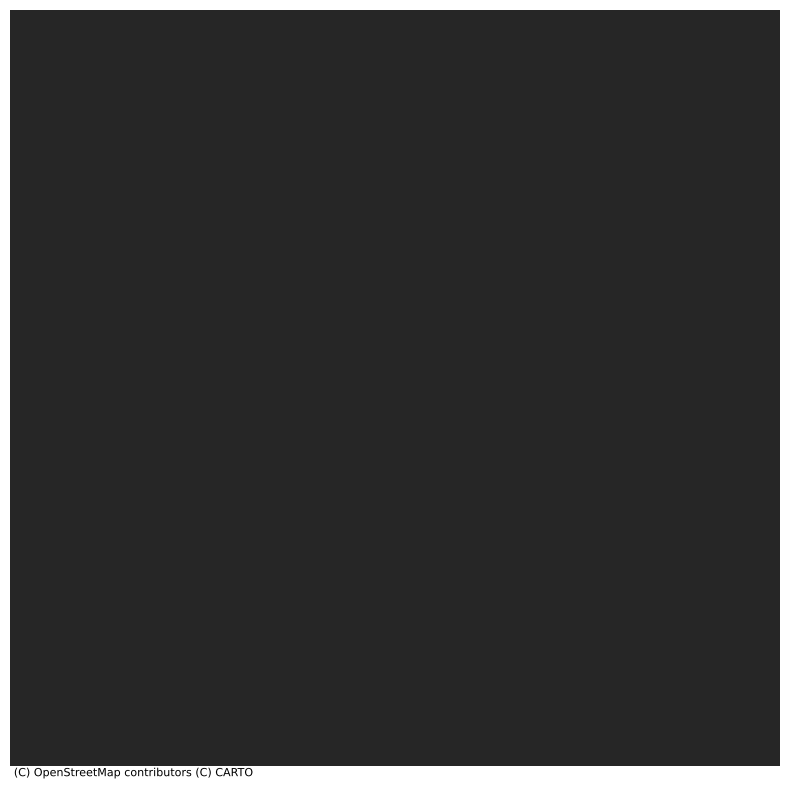

In [190]:


fig, ax = plt.subplots(1, figsize=(10, 10))

data_gdf.to_crs("EPSG:25832").plot(
    column='max_travel_time', 
    scheme='quantiles',
    ax=ax,
    cmap='winter',
    legend=True,
    legend_kwds={"loc": 4}
)

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=data_gdf.to_crs("EPSG:25832").crs,
    source=cx.providers.CartoDB.DarkMatterNoLabels
)

plt.show()

In [191]:
import plotly.figure_factory as ff
import plotly.express as px
import numpy as np

fig = ff.create_hexbin_mapbox( 
    data_frame=map_df.filter(pl.col('graph_type') == 'all').to_pandas(), lat="lat", lon="lon",
    nx_hexagon=60, opacity=0.7, labels={"color": "n"}, template=None,
    color="max_travel_time", agg_func=np.mean, color_continuous_scale="thermal", range_color=[0,30]
)
fig.update_layout(mapbox_style="carto-positron", width=1000, height=1000)
fig.update_traces(marker=dict(line=dict(width=0)))
fig.show()